# Mobile Robotics Project Report

T22 : Joelle Ayoub, Benjamin Bahurel, Sonny Alain Fernand Basso, Benjamin Louis Beretz

## 1. Project Overview
#### **Description of the project**:

The project involves placing the robot on a map filled with obstacles and having it to reach a target goal while avoiding anticipated obstacles. During its movement, the robot will additionally be able to avoid unexpected obstacles added to its path. The robot will also be able to localize itself at any time with or without access to the camera, and find its way back in case of kidnapping.

To achieve this, the robot will be equipped with an ArUco tag to determine its position using the camera. Similarly, the target goal and obstacles will also be marked with ArUco tags.

#### **Modules Overview:**

**Robot communication**

All the communication with the robot is managed trough a communication class to give a simple way of receiving data from and sending data to the thymio.

**Computer Vision:**

Ability to identify ArUco markers to track the the robot's position, to find goal coordinates and obstacles coordinates.

**Global Navigation**:

Pathfinding using a slightly modified version of the A* algorithm to avoid expected obstacles.

**Local Navigation:**

Detection and avoidance of obstacles using sensors and collision avoidance algorithm.

**Kalman Filter:**

Estimation of robot's position in case of unavailability of the camera

**Motion Control:**

Astolfi Controller to transmit wheel's speed to the robot in order to move from a point to another

## 2. Environment Setup
**Description of the Environment**: 

We are using a blank map dotted with ArUco tag to represent and extract the position of the robot, the objective to be reached and the expected obstacles. Three more ArUco tags are used in order to obtain a scale in [pxl/mm]. We can measure with a rule the distance in mm between each tag and a programme gives the same distance seen by the camera in pixels. This is especially useful for the EKF where this ratio is important in order to compute the precise distance the robot will travel in one iteration of the main program.

**Visualizations**: 

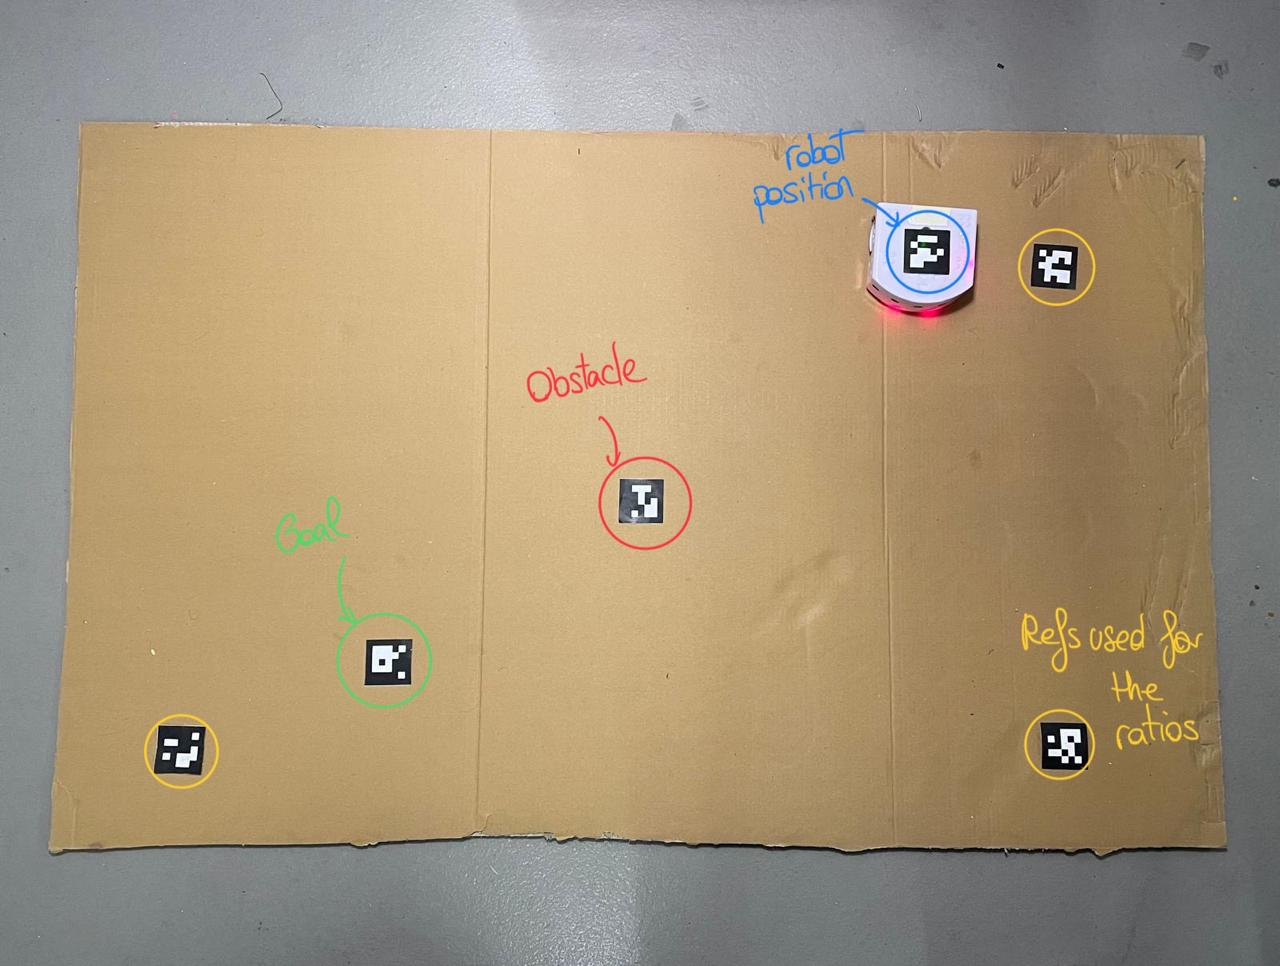

The measures give us HEIGHT_MM, WIDTH_MM, scaleHeight and scaleWidth which will be used further. 


## 3. Code Implementation

**Robot communication:**

The communication with the thymio is done using the class `Thymio_communication` which contains :
* `__init__`: Initializes the client using ClientAsync() from tdmclient, the node, and two tables for the sensors values and the motor speeds
* `_connect_to_thymio__`: Async method to connect the Thymio with `client.wait_for_node()`
* `update_sensors`: Async method to read the proximity sensors values from the thymio and write them in the sensors table of the class
* `set_motor_speeds(self, left_speed, right_speed)`: Writes the speeds given in arguments in the speeds table of the class
* `run_motor_speeds`: Async method to send the speeds of the class setted before to the motors of the Thymio

**3.1)Computer Vision:**

The computer vision system is responsible for identifying the start position, goal, obstacles, and robot's location on a mapped environment. Using OpenCV and ArUco markers, this module detects and maps objects in the workspace to a grid. The following methods and functions are used to achieve this:

•⁠  ⁠⁠ start_capture ⁠ : Initializes the video feed from the camera
•⁠  ⁠⁠ pixel_to_grid ⁠ : Converts pixel coordinates from the camera feed to grid coordinates on the map
•⁠  ⁠⁠ get_grid ⁠ : Detects and identifies AruCo markers using ⁠ cv2.aruco.detectMarkers() ⁠ to generate a grid-based map. Each marker is classified based on its ID. Obstacles are resized to include a margin taking into consideration the Thymio's size

The system also provides a live feed window displaying a real time video of our Thymio moving on the map toward the goal, captured by a camera positioned above


**3.2)Global Navigation:**

For the path planning, we decided to use the A* algorithm, provided in the course "MOBILE ROBOTS 4/5 - Navigation of
Prof. Francesco Mondada", to calculate the most optimal path. It computes costs for each cells of the map grid and skips obstacles (marked as -1 by the computer vision) during neighbor exploration:

However, we made a few modifications:

To reduce computation costs and minimize the number of points the controller needs to handle, we ensured that when the path follows a straight line — requiring the robot to move through a succession of very close points without any variation in angular error — we remove the unnecessary intermediate points. It works by checking the direction vectors between consecutive points to determine changes in direction and retain only the points where a turn occurs.

```python
# Vectors between consecutive points
vec1 = (curr[0] - prev[0], curr[1] - prev[1])
vec2 = (next[0] - curr[0], next[1] - curr[1])

# Verification of colinearity (vector product = 0)
if vec1[0] * vec2[1] != vec1[1] * vec2[0]:
    simplified_path.append(curr)
```

Additionally, the code provided in the course did not account for diagonal movements. We added this functionality to allow the robot to move in the most optimal way. To do so, the neighbors list now includes diagonal directions (Up-Left, Up-Right, Down-Left, Down-Right).

```python
(current_pos[0] - 1, current_pos[1] - 1),  # Up-Left
(current_pos[0] - 1, current_pos[1] + 1),  # Up-Right
(current_pos[0] + 1, current_pos[1] - 1),  # Down-Left
(current_pos[0] + 1, current_pos[1] + 1)   # Down-Right
```

**3.3)Local Navigation:**

The local navigation module in `local_nav.py`is based on the exercises series 3 (*Artificial neural networks*) and 4 (*Local navigation*) from the *MICRO-452 Basics of mobile robotics* course.

It uses ANN (Artificial Neural Networks) to compute the local speeds of both motors based on the IR sensors inputs, by multiplying these values by the weights of the corresponding sensors and then calculating the outputs of the neurons to set the speeds.

```python
if obstacle:
    for i in range(len(x)):
        # Get and scale inputs
        x[i] = prox_values[i] / sensor_scale
        
        # Compute outputs of neurons and set motor powers
        y[0] = y[0] + x[i] * w_l[i]
        y[1] = y[1] + x[i] * w_r[i]
```

The weights chosen for the sensors are the initial ones from the exercises and were tested experimentally to check if they worked for the obtsacle avoidance.

```python
# Weights of each sensor
    w_l = [40,  20, -20, -20, -40]
    w_r = [-40, -20, -20,  20,  40]
```

It also uses a basic FSM based on sensors values comparisons with a threshold to switch between the case `obstacle`and `not obstacle` to send differend values of speed. If no obstacle is detected, the local speeds sent are set to 0 and if one is detected, the outputs of the neurons are sent. The boolean `obstacle`is also returned to be used in the main. 

**3.4)Kalman Filter:**

In order to have an estimation of the robot at anytime and especially when we do not have the camera, we implemented an Extended Kalman Filter (EKF). The global structure of the filter is inspired by the one presented in the course "MOBILE ROBOTS 7/8 - Uncertainties" by Pr.Francesco Mondada, we decided that we would use a model based on the odometry of the robot. In other terms, we are using the speed of the motors and the geometry of the robot to compute the future estimated state of the robot. The EKF relies on the measurements of the camera (position, angle) to correct the prediction that is being made, if those measurements are not available, then the prediction is purely computational and we have to be careful about the tuning of certains variables and matrices. 

We can then estimate the estimate state $\textbf{x_{k+1}}$ ($x_{k+1}$,$y_{k+1}$,$\theta_{k+1}$) as : 

\begin{cases}
x_{k+1} = x_{k} + v * \Delta t * cos(\theta_{esti}) * ratio_x \\
y_{k+1} = y_{k} + v * \Delta t * sin(\theta_{esti}) * ratio_y\\
\theta_{k+1} = \theta_{esti}
\end{cases}


where : 
- $x_k$ is the previous estimate state ($x_k$, $y_k$, $\theta_k$)
- $v$ is computed as $\dfrac{RightSpeed-LeftSpeed}{2}$ where both speeds are obtained by multypling the readings of the motor by a factor 0.4 that represents the distance in mm per second for a motor reading of 1. 
- $\Delta t$ is the sampling time, we tuned it experimentaly in order to make the estimation the more accurate possible
- $\theta_{esti}$ is equal to $\theta_{previous} + \Delta t * \omega = \theta_{previous} + \Delta t * \dfrac{RightSpeed-LeftSpeed}{WHEEL\_GAP}$
- $ratio_{x,y}$ is a ratio that converts $v * \Delta t * cos(\theta_{esti})$ expressed in [mm] into [pxl]. Its value is fixed thanks to the environnement we chose

The mobile robot can be defined as mentionned in the course :

\begin{cases}
x_{k} = g(u_k, x_{k-1}) + \epsilon_{t} \\
y_{k} = h(x_{k-1}) + \delta_t 
\end{cases}


where :
- $\epsilon_k \sim N(0, Q)$ is a is a multinormal that models the uncertainty introduced by the state transition
- $\delta_t  \sim N(0, R)$ is a multinormal describing the measurement noise.

With $\textbf{Q}$ and $\textbf{R}$ the covariances matrices of, respectively, the noise of the process and the noise of the measure

* #### **Prediction step**

In [ ]:

    Q = np.array([[1, 0, 0], [0, 1, 0], [0, 0, 0.04]])
    
    # The 3 following variables are computed thanks to the motor reading inputs and the tuned sampling time.
    omega = (RightSpeed - LeftSpeed) / WHEEL_GAP
    theta = SAMPLING_TIME_WORKING * omega
    v = (RightSpeed + LeftSpeed) / 2

    # We build the a priori estimate at this step
    x_estimation = mu_previous_state[0]
    y_estimation = mu_previous_state[1]
    angle_estimation = mu_previous_state[2]
    angle_estimation = math.radians(angle_estimation)

    cos_angle = np.cos(theta + angle_estimation)
    sin_angle = np.sin(theta + angle_estimation)

    # This is the prediction where we compute the estimate position of the robot at the step k+1, thanks to the model presented before
    mu_prediction = np.zeros(3)
    mu_prediction[0] = x_estimation + v * SAMPLING_TIME_WORKING * cos_angle * PXL_OVER_MM_WIDTH
    mu_prediction[1] = y_estimation + v * SAMPLING_TIME_WORKING * sin_angle * PXL_OVER_MM_HEIGHT
    mu_prediction[2] = theta + angle_estimation #radians
    
    # Then we build the a priori covariance matrix of the estimate position thanks to the Jacobian 
    Jacob = np.eye(3)
    Jacob[0, 2] = -v * sin_angle
    Jacob[1, 2] = v * cos_angle
    covar_prediction = Jacob @ covar_previous_state @ Jacob.T + Q

Where the Jacobian of the system is :
Jacob =
\begin{bmatrix}
1 & 0 & -v * cos(\theta_k + \theta_{esti})  \\
0 & 1 & v * cos(\theta_k + \theta_{esti}) \\
0 & 0 & 1
\end{bmatrix}

and we choose the matrix Q as :
Q = 
\begin{bmatrix}
2 & 0 & 0 \\
0 & 2 & 0 \\
0 & 0 & 0.05
\end{bmatrix}
The matrix Q was chosen relatively large at the beginning then we reduced it until we had an estimate position that was satisfying compared to the <position given by the camera

* #### **Measurement and innovation steps**

In [ ]:
# The measurement step is where we correct or not the estimate position with the position given by the camera
# If we have a position given by the camera, the innovation won't be null and a correction will be applied to the estimate position
# If we do not have any measurements from the camera, the innovation will be null, thus, the estimate position will remained the same until
# it is returned by the function
     
    if actual_state is not None:
        y = list(actual_state)  
        y[2] = math.radians(y[2])
        y = tuple(y)                                                                                                        
    else:
        y = mu_prediction

    i = y - mu_prediction

In [ ]:
# When the innovation is not null, the estimate position is corrected by a K gain computed as follows which will lead to a new estimate 
#position that will be more close top the real position of the robot
    
    S = covar_prediction + R
    S_inv = np.linalg.inv(S)
    K = covar_prediction @ S_inv

    x_estimation = mu_prediction + K @ i
    covar_estimation = covar_prediction - K @ covar_prediction
    x_estimation[2] = math.degrees(x_estimation[2])
    x_estimation[2] = x_estimation[2]%360  #Here is a step to keep the final angle between [0;2pi], which is important for other modules

The same way we did for the matrix Q, the matrix R : 
R = 
\begin{bmatrix}
2 & 0 & 0 \\
0 & 2 & 0 \\
0 & 0 & 0.05
\end{bmatrix}
was computed empirically by slowly decreasing the coefficients until we had a good result.

* #### **Full-implementation**

Inputs : 
- actual_state : state of the robot given by the camera
- mu_previous_state : estimate state of the robot at step (k-1)
- covar_previous_state : estimate covariance of the state at step (k-1)
- LeftMotor_Speed : speed input of the left motor of the robot
- RightMotor_Speed : speed input of the right motor of the robot
- scaleHeight,scaleWidth : values to compute the $ratio_{x,y}$, giving length reference for x and y axis in pxls

Outputs : 
- x_estimation : estimate state of the robot at step (k)
- covar_estimation : estimate covariance of the state at step (k)


In [ ]:
from typing import Optional

import numpy as np
import math

WHEEL_GAP = 96
SAMPLING_TIME = 0.107
GAIN_SAMPLING = 0.8
#HEIGHT and WIDTH measured on the environment
HEIGHT_MM = 594
WIDTH_MM = 865
SAMPLING_TIME_WORKING = GAIN_SAMPLING * SAMPLING_TIME

def Kalman_filtering(actual_state: Optional[np.ndarray], mu_previous_state: np.ndarray, covar_previous_state: np.ndarray, 
                     LeftMotor_Speed: float, RightMotor_Speed: float, scaleHeight: float, scaleWidth: float) -> tuple[np.ndarray, np.ndarray]:
    """ Extended Kalman filtering for robot poisiton estimation """   

    PXL_OVER_MM_HEIGHT = HEIGHT_MM / scaleHeight
    PXL_OVER_MM_WIDTH = WIDTH_MM / scaleWidth

    Q = np.array([[1, 0, 0], [0, 1, 0], [0, 0, 0.04]])
    R = np.array([[1, 0, 0], [0, 1, 0], [0, 0, 0.04]])
    
    RightSpeed = RightMotor_Speed*0.4 #mm/s
    LeftSpeed = LeftMotor_Speed*0.4
    
    omega = (RightSpeed - LeftSpeed) / WHEEL_GAP
    theta = SAMPLING_TIME_WORKING * omega
    v = (RightSpeed + LeftSpeed) / 2

    x_estimation = mu_previous_state[0]
    y_estimation = mu_previous_state[1]
    angle_estimation = mu_previous_state[2]
    angle_estimation = math.radians(angle_estimation)

    cos_angle = np.cos(theta + angle_estimation)
    sin_angle = np.sin(theta + angle_estimation)

    mu_prediction = np.zeros(3)
    mu_prediction[0] = x_estimation + v * SAMPLING_TIME_WORKING * cos_angle * PXL_OVER_MM_WIDTH
    mu_prediction[1] = y_estimation + v * SAMPLING_TIME_WORKING * sin_angle * PXL_OVER_MM_HEIGHT
    mu_prediction[2] = theta + angle_estimation #radians
    
    Jacob = np.eye(3)
    Jacob[0, 2] = -v * sin_angle
    Jacob[1, 2] = v * cos_angle
    covar_prediction = Jacob @ covar_previous_state @ Jacob.T + Q

    if actual_state is not None:
        y = list(actual_state)  # Convert tuple to list
        y[2] = math.radians(y[2])  # Angle in radians
        y = tuple(y)  # Convert back to tuple if needed                                                                                                          
    else:
        y = mu_prediction

    i = y - mu_prediction
    
    S = covar_prediction + R
    S_inv = np.linalg.inv(S)
    K = covar_prediction @ S_inv

    x_estimation = mu_prediction + K @ i
    covar_estimation = covar_prediction - K @ covar_prediction
    x_estimation[2] = math.degrees(x_estimation[2])
    x_estimation[2] = x_estimation[2]%360
 

    return x_estimation, covar_estimation

**3.5)Motion Control:**

The motion control module in `astolfi.py` is a simple astolfi controller, modified to only use the angle correction with a fixed linear speed.
The function `motor_controller()` receives the `actual state` (the position of the robot, from the camera or the kalman filter) and the `goal_state` (the next point to reach in the path). Based on the coordinates and the angle of the robot, it calculates the error in distance and angle to reach the target and computes the angular speed by multiplying the error by a gain `k_alpha`.

The linear speed is set to 0 until the angle erros goes down to a defined threshold in order to optimize the angular correction before starting moving forward.  

## 4. Integration and Overall System
**Explication of the main part by part**:


The main starts with the import of the different modules and libraries we used in order to make the system working

In [ ]:
from mapping import get_grid
from mapping import reset_grid
from Path_planning import a_star_search
from Path_planning import simplify_path
from kalman import Kalman_filtering
from astolficontrol import motor_controller
from local_nav import local_speeds
from tdmclient import ClientAsync, aw

import matplotlib.pyplot as plt
import numpy as np
import cv2
import time
import math

 This part of the code is used to initialize the connection with the Thymio, to collect the values of the IR sensor and send to the Thymio the speed the motors have to take, in an asynchronous way.

In [ ]:
lass Thymio_communication:
    def __init__(self):
        """ Initialization of the connection with the Thymio via TDMclient, and of the sensors and speeds values """
        self.client = ClientAsync()
        self.node = None
        self.sensors = [0] * 5  # Front IR sensors
        self.motor_speeds = [0, 0]  # [left, right]

    async def _connect_to_thymio_(self):
        """ Node configuration for the connection """
        self.node = await self.client.wait_for_node()
        print("Thymio connected")
        await self.node.lock()

    async def update_sensors(self):
        """ Reading of the sensors values from the Thymio and update of the sensors values in the class """
        await self.node.wait_for_variables({"prox.horizontal"})
        if "prox.horizontal" in self.node:
            self.sensors = self.node["prox.horizontal"]

    def set_motor_speeds(self, left_speed, right_speed):
        """ Setting of the motors' speeds values in the class """
        self.motor_speeds = [left_speed, right_speed]

    async def run_motor_speeds(self):
        """ Sending the speeds to the motors """
        aw(self.node.set_variables({"motor.left.target": [self.motor_speeds[0]], "motor.right.target": [self.motor_speeds[1]],}))
        self.node.flush()

Then, some variables that are used in the main While are initialized to prevent any hazardous outcomes.

In [ ]:
# Kalman filter parameters initialization
    mu_k = None  # Initial state
    covar_k = np.eye(3) * 0.1  # Initial covariance matrix

    # Parameters initialization, state vars
    speedL = 0
    speedR = 0
    enable_path = True
    prev_state = False
    robot_visible = True
    first_loop = True
    kidnapping = False
    recomputed = False

Finally, the main part of the program that handles the different cases where the robot can be involved.

Below the code to run on the Thymio

In [ ]:
from mapping import get_grid
from mapping import reset_grid
from Path_planning import a_star_search
from Path_planning import simplify_path
from kalman import Kalman_filtering
from astolficontrol import motor_controller
from local_nav import local_speeds
from tdmclient import ClientAsync, aw

import matplotlib.pyplot as plt
import numpy as np
import cv2
import time
import math

class Thymio_communication:
    def __init__(self):
        """ Initialization of the connection with the Thymio via TDMclient, and of the sensors and speeds values """
        self.client = ClientAsync()
        self.node = None
        self.sensors = [0] * 5  # Front IR sensors
        self.motor_speeds = [0, 0]  # [left, right]

    async def _connect_to_thymio_(self):
        """ Node configuration for the connection """
        self.node = await self.client.wait_for_node()
        print("Thymio connected")
        await self.node.lock()

    async def update_sensors(self):
        """ Reading of the sensors values from the Thymio and update of the sensors values in the class """
        await self.node.wait_for_variables({"prox.horizontal"})
        if "prox.horizontal" in self.node:
            self.sensors = self.node["prox.horizontal"]

    def set_motor_speeds(self, left_speed, right_speed):
        """ Setting of the motors' speeds values in the class """
        self.motor_speeds = [left_speed, right_speed]

    async def run_motor_speeds(self):
        """ Sending the speeds to the motors """
        aw(self.node.set_variables({"motor.left.target": [self.motor_speeds[0]], "motor.right.target": [self.motor_speeds[1]],}))
        self.node.flush()

async def prog():
    """ General initialization """

    # Connection with the Thymio
    thymio_comm = Thymio_communication()
    await thymio_comm._connect_to_thymio_() 

    # Kalman filter parameters initialization
    mu_k = None  # Initial state
    covar_k = np.eye(3) * 0.1  # Initial covariance matrix

    # Parameters initialization, state vars
    speedL = 0
    speedR = 0
    enable_path = True
    prev_state = False
    robot_visible = True
    first_loop = True
    kidnapping = False
    recomputed = False
    scaleHeight = 570
    scaleWidth = 780
    
    cam = True
    
    while True:
        # Set and run the speeds of the motors at each iteration
        thymio_comm.set_motor_speeds(speedL,speedR)
        await thymio_comm.run_motor_speeds()
        
        # Read the IR sensors values and write them into a local table
        await thymio_comm.update_sensors()
        sensors = thymio_comm.sensors
        
        # Creation of the grid and recognition of the environment from the camera
        grid, start_pos, goal_pos, start_angle, robot_pos = get_grid()
        print("Position of the robot after grid calculation : ", robot_pos)
        print(goal_pos)
        
        if robot_pos is None:
            reset_grid()
            grid, start_pos, goal_pos, start_angle, robot_pos = get_grid()
            if goal_pos is None:
                cam = False
            else:
                cam = True

        if grid is None or goal_pos is None:
            print("Impossible to generate the grid or to detect the target")
            continue    
            
        # Robot kidnapped
        if robot_pos is None and goal_pos is not None:  # robot kidnappé mais map toujours visible
            print("Robot non visible, waiting...")
            kidnapping = True
            continue
            
        if robot_pos is not None and recomputed is True: # robot reaparait apres kidnapping et le path a été recompute
            recomputed = False
            continue
        
        if robot_pos is not None and kidnapping is True: #robot reapparait et a été kidnappé alors on reset la grid
            if not recomputed:
                print("Path calculation after kidnapping")
                enable_path = True
                kidnapping = False
                reset_grid()
                recomputed = True
            continue
            
        # Path calculation if possible
        if enable_path:
            path, explored, operation_count = a_star_search(grid, start_pos, goal_pos)

            # Plot of the first path determined (each point of the trajectory)
            x_coords, y_coords = zip(*path)

            plt.figure(figsize=(8, 8))
            plt.plot(x_coords, y_coords, marker='o', markersize=2, linewidth=0.5)
            plt.title(" Trajectory (x, y)")
            plt.xlabel("X")
            plt.ylabel("Y")
            plt.grid(True)
            plt.show()

            # Simplification of the path by keeping the trajectory changes only
            path = simplify_path(path)
            print("Path calculted")
            enable_path = False

        # Navigation and motor control
        if path:
            next_point = path[0]  # Next point to reach in the path

            if first_loop:
                mu_k = robot_pos
                first_loop = False

            # Speeds calculation using the actual position of the robot if it is visible
            if robot_pos is not None:
                print("Motor control using the actual robot position : ",robot_pos)
                motor_left, motor_right, goal_reached = motor_controller(robot_pos, next_point)

            # Speeds calculation using the estimated position of the robot if the camera is hidden
            if cam is False:
                motor_left, motor_right, goal_reached = motor_controller(mu_k, next_point)

            # Local verification for obstacle avoidance using the IR sensors values
            local_state, local_speed_left, local_speed_right = local_speeds(sensors)

            # If the robot sees an obstacle, remember it for next iteration
            if local_state and not kidnapping:
                prev_state = True

            # If the robot just avoided an obstacle, recalcute the path and move forward to avoid going into it again
            if (not local_state) and prev_state:
                enable_path = True
                prev_state = False
                thymio_comm.set_motor_speeds(200,200)
                await thymio_comm.run_motor_speeds()
                time.sleep(1.5)

            # Speeds calculation using both global (the controller) and local (if obstacle) lavigations
            speedL = motor_left + local_speed_left
            speedR = motor_right + local_speed_right
            # Keep an int value
            speedL = round(speedL)
            speedR = round(speedR)

            # Kalman filter update
            mu_k, covar_k = Kalman_filtering(robot_pos, mu_k, covar_k, speedL, speedR, scaleHeight, scaleWidth)
            print(f"Estimation EKF : {mu_k}")

            # If next point in the path reached, remove it
            if goal_reached:
                print(f"Next point reached : {next_point}")
                path.pop(0)
        
        # Manual exit from the program
        if cv2.waitKey(1) & 0xFF == ord('x'):
            break

        await thymio_comm.client.sleep(0.1)

    # Closing of the program
    await thymio_comm.client.close()
    print("Programme terminé.")


# Async run of the main code
if __name__ == "__main__":
    with ClientAsync() as client:
        client.run_async_program(prog)

## 5. Simulation and Results

Main Loop

1. Initialization and Motor Control
    The connection with the robot is established to:
    - Set and execute motor speeds.
    - Update and read values from the IR sensors.

2. Environment Analysis and Path Calculation
    - The environment grid, the robot's position, and the goal position are retrieved.
    - A path is calculated for the robot to follow.

3. Handling the "Kidnapping" Case
    - **When the robot is "kidnapped":**
      - The robot is not visible, but the goal is detected.
      - This situation is different from when the camera is hidden.
    - **When the robot is no longer "kidnapped":**
      - The robot’s position becomes visible again.
      - The path is recomputed, and the kidnapping status is reset and the code resumes normally.

4. Handling the Hidden Camera Case
    - If the robot and the goal are not visible, the camera is considered hidden and the camera status is updated.

5. Path Computation
    When a valid path is available:
    - The path is calculated using the **A*** algorithm.
    - The path is simplified to retain only significant trajectory changes.
    - Path computation is disabled until required again.

6. Navigation and Motor Control
    - Identify the next target point in the path.
    - **If the camera is active:**
      - Motor speeds are calculated using the actual robot position and sent to the robot.
    - **If the camera is hidden:**
      - Motor speeds are calculated using the estimated position from the Kalman filter.
    - Detect obstacles using IR sensors and adjust motor speeds for local obstacle avoidance.
    - If an obstacle is avoided, path computation is re-enabled to update the route.
    - Use the **Kalman filter** to:
      - Update the robot's estimated position.
      - Combine global (path-following) and local (obstacle-avoidance) navigation.
    - Once the current target point is reached, move to the next point in the path.


By running the main, the robot react positively to several cases that were imposed for the project :
- the program build a grid and a path thanks to the camera 
- the robot follow the path until the goal is reached without encountering the predetermined obstacles given by the computer vision
- the robot avoid locally unknown obstacles that the camera can't see
- the robot react to a case of "kidnapping' where the robot is suddenly placed somewhere else on the map

Unfortunately, the robot is unable to reach the goal position when the camera is hidden. This issue arises because when we check if the robot has disappeared, resets the goal position to None and recalculate the goal position( which is suppose to stay at none if the cam is hidden), the goal position never actually updates to None. Thus, the camera's state never changes to False, and motor speeds are never calculated using the estimated position from the Kalman filter, leading to a wrong motion a the robot when the camera is hidden.

⁠We also encountered some more fundamentals difficulties with the Kalman Filter. Indeed, the first problem was about the unities of the different variables, that were for most of them different, which we had to balance in order to make the system works. The second problem was about the tuning of the filter, which is a problem that has not been fully solved, but by tuning the sampling time and the matrices R and Q, we were approaching a beginning of good solution. But we lacked of time to make it works perfectly.

## 6. Conclusion

The project was great way to learn how to work in group, especially on a project where the link between every modules is really important and the assembly can represent a really challenging task, maybe even too challenging. It was really interesting to apply what we have seen during the courses and the TP in a concrete project with real o bjectives. At the end, the robot works, but does not everything that was requested even if we have some clues about how to solve it, we could not manage to do it in time.

We felt like the part on the computer vision was a bit obscure and really hard to implement by ourselves, so maybe a course about how to use the camera proprely could have been interesting. 

Sources :
•⁠  ⁠"MOBILE ROBOTS 4/5 - Navigation" by Prof. Francesco Mondada
•⁠  ⁠exercises series 3 (Artificial neural networks) and 4 (Local navigation) from the MICRO-452 Basics of mobile robotics course.
•⁠  ⁠"MOBILE ROBOTS 7/8 - Uncertainties" by Pr.Francesco
•⁠  ⁠OpenCV and ArUco libraries
•  https://automaticaddison.com/how-to-detect-aruco-markers-using-opencv-and-python/
•  ChatGPT